# <center> IPS MODELLING (Part 3) </center>

There are numerous different techniques we can use to estimate the location of a device from the strength of the signal detected between the device and several access points. We will start with a relatively simple and intuitive approach, k-nearest neighbors (k-NN)



Recap:
 - **PART 1**: THE DATA 
   - How was the data collected and formated?
   - analyze the recordings, check, select and clean noise
   - bring the recordings in a form suitable for analysis
 - **PART 2**: EDA and FE
   - what affects the SS? We saw that orientation impacts SS, so when we predict we should use recordings with the same/similar orientations. 
      - The number of similar orientations to consider will be another hyperparameter we can tune.
   
   - Are the distributions of SS skewed?
   - How is SSs relationship to distance? should we model a logarithmic or a linear relationship?
   - We should have 110 replications for the measurements at each location-orientation combination, average these to eliminate noise and get a representative signal value (This will be used as features for modelling)
      
In this part, **PART 3**, we will concentrate on modelling


Q: What is the general problem with supervised learning?

## Utility functions from previous parts

In [2]:
offline_pivoted = APsignals(offline)
display(offline_pivoted.head(10))

mac,posXY,posX,posY,orientation,orientation_rounded,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0.0-0.0,0.0,0.0,0.0,0,-51.154545,-66.510870,-64.054348,-39.161290,-67.310345,-56.394231
1,0.0-0.0,0.0,0.0,45.2,45,-57.445455,-67.468085,-62.420455,-43.148936,-68.719512,-56.465909
2,0.0-0.0,0.0,0.0,90.3,90,-50.585586,-62.595506,-63.747253,-33.744681,-63.085366,-55.170213
3,0.0-0.0,0.0,0.0,135.9,135,-51.517857,-67.476190,-63.366667,-39.103093,-63.632911,-54.322581
4,0.0-0.0,0.0,0.0,180.3,180,-55.027273,-68.295238,-62.428571,-33.970000,-65.978022,-56.500000
5,0.0-0.0,0.0,0.0,225.6,225,-54.627273,-64.891304,-64.012048,-36.247312,-66.208791,-54.112245
6,0.0-0.0,0.0,0.0,270.1,270,-54.636364,-67.931373,-68.060976,-38.593750,-64.313953,-57.946809
7,0.0-0.0,0.0,0.0,315.0,315,-52.827273,-64.150000,-68.174419,-46.989247,-68.024390,-59.272727
8,0.0-1.0,0.0,1.0,0.7,0,-50.572727,-66.894118,-70.400000,-42.750000,-63.022989,-56.861702
9,0.0-1.0,0.0,1.0,45.7,45,-52.600000,-68.947917,-61.165049,-42.180851,-64.585366,-59.274725


In [3]:
offline_pivoted_2 = APsignals(offline, columns=["posXY", "posX", "posY"])
display(offline_pivoted_2.head(10))

mac,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0.0-0.0,0.0,0.0,-53.469989,-66.241335,-64.477952,-38.823684,-65.925000,-56.285156
1,0.0-1.0,0.0,1.0,-52.905575,-66.169935,-65.700831,-39.772087,-65.497817,-58.028646
2,0.0-10.0,0.0,10.0,-55.259681,-65.046768,-66.334770,-45.386973,-65.744838,-52.094928
3,0.0-11.0,0.0,11.0,-54.170648,-67.937158,-68.846583,-48.007926,-66.576923,-55.192555
4,0.0-12.0,0.0,12.0,-54.450000,-68.096599,-70.866109,-45.607643,-68.258308,-53.444727
5,0.0-13.0,0.0,13.0,-54.846591,-70.764940,-72.106534,-45.447917,-68.547112,-55.117497
6,0.0-2.0,0.0,2.0,-55.887628,-62.128571,-62.125554,-43.651671,-62.763271,-55.160574
7,0.0-3.0,0.0,3.0,-55.543182,-63.221477,-56.002813,-41.138677,-62.111425,-54.355731
8,0.0-4.0,0.0,4.0,-52.046644,-64.174707,-59.315501,-42.611702,-62.678822,-54.055046
9,0.0-7.0,0.0,7.0,-56.077361,-64.321381,-64.227205,-45.802993,-54.561254,-57.969333


## K-NN, what do we need?

We want to predict the location of a new point based on how similar the signals from the 6 AP are. As we mentioned already, since the orientation impacts signal, we will subset the data and select only recordings with same/similar orientations

- we choose k neighbours, by calculating the similarity between the vectors of 6 values.
- what kind of similarity can we use? 
    - Euclidian Distance (L2 Norm)
    - Dot product
    - Cosine Similarity
    - Manhattan Distance (L1 Norm)
    - Minkowski Distance (Lp Norm)
    - ...
Please reflect what these metrics measure and when to use them.

Are all access points of equal importance or should we distinguish between close and far access points? 

Which other features can we consider and how can we include them in the analysis?
- We already argued that  orientation impacts the recorded signals and hence taking a subset of the data makes sense.

## Modeling baseline: k-NN

- is a simple approach, to set the benchmark
- We naturally think of measuring the distance between two sets of signal strengths with Euclidean distance, i.e. we compare vectors of size 6

 $\sqrt{(\sum (s_i^*-s_i)^2)}$, where 
 - $s_i$ is the signal strength measured between the hand-held device and the i-th access point for a training observation taken at some specified location, and
 - $s^*_i$ is the signal measured between the same access point and our new point whose (x, y) values we are trying to predict.


- Read about K-NN
    - non-parametric, classification or regression.
    - training: just storing the offline data
    - new point = a new set of signal strengths for a location that is not known, 
    - we find the k observations in our training data that is closest to this new observation and 
    - we estimate the new observation's position by an aggregation of the positions of the k training points (e.g. mean or weighted mean)

Downside 

   - We assume similarity of the new data to the offline data
   - Hence we can only consider known AP's and we would need new measurements if anything changes

## Preparing and Analyzing the online data set


### Number of new measurements


### The Distribution of new signals

Look at how the 60 new recorded signals are distributed in location and angle.

### Bringing the online data in a form suitable for prediction

When we consider similarity between two measurements we will look at a vector of 6 SS values for each of the measurements, and we calculate the distance between these.

We hence reorganize the data to have one column representing each of the 6 APs, and the values will be the average signal strength measured for that AP at each location. The measurements are repeated to ensure that the noise affects the values less (regression to the mean)

## Selecting m similar angles

We saw that we have only **one orientation** for each location.



For each new point, we want to find records in our offline data set, that have similar to our new observation. Since we saw that orientation impacts the signal, we should choose records with similar orientations. We could use records with an orientation that is within a specified range of the new point's orientation, i.e. m, the number of neighboring angles. This will be a parameter for our model as well, along with k, the number of neighboring points.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from utils import *

offline = read_data('./data/offline.final.trace.txt')
offline = preprocessing(offline)
# ending _v2 will be used throughout the notebook to mark the dataset where mac 00:0f:a3:39:e1:c0 instead of 00:0f:a3:39:dd:cd as been removed from the dataset
offline_v2 = offline.copy()
submacs= ['00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a',
          '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:90', '00:14:bf:b1:97:8d',
          '00:14:bf:b1:97:81']
submacs_v2 = submacs.copy()
submacs.remove(submacs[1])
submacs_v2.remove(submacs_v2[0])
offline = offline[offline['mac'].isin(submacs)].copy()
offline_v2 = offline_v2[offline_v2['mac'].isin(submacs_v2)].copy()
display(offline.head(10))
display(offline.info())
display(offline["mac"].unique())
display(offline_v2["mac"].unique())

def APsignals(data, 
              columns=["posXY", "posX", "posY", "orientation", "orientation_rounded"], 
              pivot_by ='mac',
              averaging_col='signal', 
              agg_fct='mean'):
    ''' this function returns the data containing the representative signal as the averages of signals for each mac for the given grouping columns'''
    pivoted_data = data.pivot_table(values=averaging_col, index=columns, aggfunc=agg_fct, columns=[pivot_by]).reset_index()
    return pivoted_data


Parsed 1181628 measurements.
reference APs: ['00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:90', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:81']


,rawTime,scanMac,posX,posY,orientation,mac,signal,channel,time,posXY,orientation_rounded
0,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,2006-02-11 07:31:58.358,0.0-0.0,0
1,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,2006-02-11 07:31:58.358,0.0-0.0,0
2,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,2006-02-11 07:31:58.358,0.0-0.0,0
3,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,2006-02-11 07:31:58.358,0.0-0.0,0
4,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,2006-02-11 07:31:58.358,0.0-0.0,0
5,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,2006-02-11 07:31:58.358,0.0-0.0,0
11,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,2006-02-11 07:31:58.744,0.0-0.0,0
12,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-54,2462000000,2006-02-11 07:31:58.744,0.0-0.0,0
13,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,2006-02-11 07:31:58.744,0.0-0.0,0
14,1139643118744,00:02:2D:21:0F:33,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-67,2432000000,2006-02-11 07:31:58.744,0.0-0.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 759627 entries, 0 to 1181625
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   rawTime              759627 non-null  int64         
 1   scanMac              759627 non-null  object        
 2   posX                 759627 non-null  float64       
 3   posY                 759627 non-null  float64       
 4   orientation          759627 non-null  float64       
 5   mac                  759627 non-null  object        
 6   signal               759627 non-null  int64         
 7   channel              759627 non-null  int64         
 8   time                 759627 non-null  datetime64[ns]
 9   posXY                759627 non-null  object        
 10  orientation_rounded  759627 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 69.5+ MB


None

array(['00:14:bf:b1:97:8a', '00:14:bf:b1:97:90', '00:0f:a3:39:e1:c0',
       '00:14:bf:b1:97:8d', '00:14:bf:b1:97:81', '00:14:bf:3b:c7:c6'],
      dtype=object)

array(['00:14:bf:b1:97:8a', '00:14:bf:b1:97:90', '00:14:bf:b1:97:8d',
       '00:14:bf:b1:97:81', '00:14:bf:3b:c7:c6', '00:0f:a3:39:dd:cd'],
      dtype=object)

In [4]:
round_orientation(22.4), round_orientation(22.51)

(0, 45)

In [5]:
def nearest_angles(observed_angle, count):
    """
    Identify the nearest 'count' angles to a given observed angle, 
    from the set {0, 45, 90, ..., 315} degrees, considering circular wrap-around.

    Parameters:
    - observed_angle (float): The angle measurement in degrees.
    - count (int): The number of closest angles to return.

    Returns:
    - List[int]: The list of the 'count' nearest angles.
    """
    # All possible orientations at 45° increments
    candidates = [i * 45 for i in range(8)]  # [0, 45, 90, ..., 315]

    # Wrap the observed angle into [0, 360)
    normalized = observed_angle % 360

    # Compute shortest circular distance between normalized angle and each candidate
    angle_distances = []
    for angle in candidates:
        diff = abs(angle - normalized)
        circular_diff = min(diff, 360 - diff)
        angle_distances.append((angle, circular_diff))

    # Sort by ascending distance and pick the top 'count' angles
    angle_distances.sort(key=lambda x: x[1])
    closest = [angle for angle, _ in angle_distances[:count]]

    return closest


m = 3
angle_new_obs = 220
angles = nearest_angles(angle_new_obs, m)
print(angles)



[225, 180, 270]


### Subsetting the data
We will subset the data to only consider neighbouring angles and we aggregate the signal strengths from the angles and create a data structure that is similar to onlineSummary, containing the avg signals from the 6 AP.

### Finding the neighbors and averaging

To find the nearest neighbors (in the subset with similar orientations) we need to calculate the distance from the new point to all observations in the training set.

The location of the new observation could be the average of the locations of the first k neighbors.

Better, of course, would be to differentiate between the points. This is left for you as an exercise.

Towards this end, we can use weights in the average that are inversely proportional to the distance (in signal strength) from the test observation. 

The weights might be $\frac{\frac{1}{d_i}}{\sum_{i=1}^{k}\frac{1}{d_i}}$ for the i-th closest neighboring observation. In this case, we would also need to return the distance values. 

In [6]:
def pred_xy(online_reshaped, offline_summary, num_angles=1, k=3):
    """
    Estimate X,Y coordinates for each new observation by finding the k closest
    records in offline_summary that have one of the num_angles nearest orientations,
    then computing the simple average of their positions.

    Parameters:
    - online_reshaped: pd.DataFrame with an 'orientation_rounded' column plus one column per MAC (e.g. '00:11:22:33:44:55').
    - offline_summary: pd.DataFrame with ['posX','posY','orientation_rounded'] plus the same MAC‐columns.
    - num_angles: how many adjacent 45° bins to include.
    - k: number of nearest neighbors in signal‐space.

    Returns:
    - pd.DataFrame with columns ['predX','predY'].
    """
    est_xy = []

    # 2) Detect MAC columns (they all contain a colon)
    signal_cols = [c for c in online_reshaped.columns if ':' in c]

    for _, test_row in online_reshaped.iterrows():
        # 3) Find the nearest orientation bins
        target_bins = nearest_angles(test_row['orientation'], num_angles)

        # 4) Subset offline to those bins
        candidates = offline_summary[
            offline_summary['orientation_rounded'].isin(target_bins)
        ].copy()

        # 5) Extract only the signal matrix and cast to float
        sig_cand = candidates[signal_cols].astype(float)
        sig_test = test_row[signal_cols].astype(float)

        # 6) Compute Euclidean distances
        diffs = sig_cand.subtract(sig_test, axis=1)  # DataFrame of floats
        # now a purely numeric array
        distances = np.linalg.norm(diffs.to_numpy(), axis=1)

        candidates['signal_distance'] = distances

        # 7) Pick k nearest and average their X/Y
        neighbors = candidates.nsmallest(k, 'signal_distance')
        est_x = neighbors['posX'].mean()
        est_y = neighbors['posY'].mean()

        est_xy.append([est_x, est_y])

    return pd.DataFrame(est_xy, columns=['predX','predY'])


In [7]:

def plot_estimates(train, test, est_var, title='Estimated vs. Actual Positions'):
    fig, ax = plt.subplots(figsize=(8, 6))
      
    ax.scatter(train['posX'], train['posY'], color="blue", s=1, label='Training positions')
    ax.scatter(test['posX'], test['posY'], color='green', s=10, label='True positions')
    ax.scatter(est_var.iloc[:, 0], est_var.iloc[:, 1], color='red', s=10, label='Estimated positions')

    # Draw lines between true and estimated positions
    for i in range(len(est_var)):
        x_coords = [test.iloc[i]['posX'], est_var.iloc[i, 0]]
        y_coords = [test.iloc[i]['posY'], est_var.iloc[i, 1]]
        ax.plot(x_coords, y_coords, color='red', alpha=0.3, linewidth=0.8)

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:

def compute_position_rmse(pred_df, true_df,
                          pred_cols=('predX','predY'),
                          true_cols=('posX','posY')):
    """
    Compute RMSE between predicted and actual 2D positions.

    Parameters
    ----------
    pred_df : pd.DataFrame
        Must contain columns pred_cols (default ('predX','predY')).
    true_df : pd.DataFrame
        Must contain columns true_cols (default ('posX','posY')).
    pred_cols : tuple of str
        Column names for the predictions in pred_df.
    true_cols : tuple of str
        Column names for the ground-truth positions in true_df.

    Returns
    -------
    float
        The root-mean-square error over all points:
            sqrt(mean( (predX-posX)**2 + (predY-posY)**2 ))
    """
    # extract and convert to numeric arrays
    P = pred_df[list(pred_cols)].to_numpy(dtype=float)
    T = true_df[list(true_cols)].to_numpy(dtype=float)

    # squared errors per point
    se = np.sum((P - T)**2, axis=1)

    # mean + sqrt
    rmse = np.sqrt(np.mean(se))
    return rmse

In [36]:
online = read_data('./data/online.final.trace.txt')
online_reshaped = preprocessing(online)
online_reshaped_v2 = online_reshaped.copy()
online_reshaped = online_reshaped[online_reshaped['mac'].isin(submacs)].copy()
online_reshaped_v2 = online_reshaped_v2[online_reshaped_v2['mac'].isin(submacs_v2)].copy()
display(online_reshaped.head(10))
display(online_reshaped.info())


Parsed 53303 measurements.
reference APs: ['00:0f:a3:39:dd:cd', '00:0f:a3:39:e1:c0', '00:14:bf:b1:97:8a', '00:14:bf:b1:97:90', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:81']


,rawTime,scanMac,posX,posY,orientation,mac,signal,channel,time,posXY,orientation_rounded
0,1139692477303,00:02:2D:21:0F:33,0.0,0.05,130.5,00:14:bf:b1:97:8a,-43,2437000000,2006-02-11 21:14:37.303,0.0-0.05,135
1,1139692477303,00:02:2D:21:0F:33,0.0,0.05,130.5,00:0f:a3:39:e1:c0,-52,2462000000,2006-02-11 21:14:37.303,0.0-0.05,135
2,1139692477303,00:02:2D:21:0F:33,0.0,0.05,130.5,00:14:bf:3b:c7:c6,-62,2432000000,2006-02-11 21:14:37.303,0.0-0.05,135
3,1139692477303,00:02:2D:21:0F:33,0.0,0.05,130.5,00:14:bf:b1:97:81,-58,2422000000,2006-02-11 21:14:37.303,0.0-0.05,135
4,1139692477303,00:02:2D:21:0F:33,0.0,0.05,130.5,00:14:bf:b1:97:8d,-62,2442000000,2006-02-11 21:14:37.303,0.0-0.05,135
5,1139692477303,00:02:2D:21:0F:33,0.0,0.05,130.5,00:14:bf:b1:97:90,-57,2427000000,2006-02-11 21:14:37.303,0.0-0.05,135
11,1139692477555,00:02:2D:21:0F:33,0.0,0.05,130.5,00:14:bf:b1:97:8a,-43,2437000000,2006-02-11 21:14:37.555,0.0-0.05,135
13,1139692477555,00:02:2D:21:0F:33,0.0,0.05,130.5,00:0f:a3:39:e1:c0,-52,2462000000,2006-02-11 21:14:37.555,0.0-0.05,135
14,1139692477555,00:02:2D:21:0F:33,0.0,0.05,130.5,00:14:bf:b1:97:90,-57,2427000000,2006-02-11 21:14:37.555,0.0-0.05,135
15,1139692477555,00:02:2D:21:0F:33,0.0,0.05,130.5,00:14:bf:b1:97:8d,-64,2442000000,2006-02-11 21:14:37.555,0.0-0.05,135


<class 'pandas.core.frame.DataFrame'>
Index: 34166 entries, 0 to 53300
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   rawTime              34166 non-null  int64         
 1   scanMac              34166 non-null  object        
 2   posX                 34166 non-null  float64       
 3   posY                 34166 non-null  float64       
 4   orientation          34166 non-null  float64       
 5   mac                  34166 non-null  object        
 6   signal               34166 non-null  int64         
 7   channel              34166 non-null  int64         
 8   time                 34166 non-null  datetime64[ns]
 9   posXY                34166 non-null  object        
 10  orientation_rounded  34166 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 3.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 34189 entries, 0 to 53301
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   rawTime              34189 non-null  int64         
 1   scanMac              34189 non-null  object        
 2   posX                 34189 non-null  float64       
 3   posY                 34189 non-null  float64       
 4   orientation          34189 non-null  float64       
 5   mac                  34189 non-null  object        
 6   signal               34189 non-null  int64         
 7   channel              34189 non-null  int64         
 8   time                 34189 non-null  datetime64[ns]
 9   posXY                34189 non-null  object        
 10  orientation_rounded  34189 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 3.1+ MB


None

In [46]:
online_reshaped = APsignals(online_reshaped, columns=["posXY", "posX", "posY", "orientation"])
online_reshaped_v2 = APsignals(online_reshaped_v2, columns=["posXY", "posX", "posY", "orientation"])
display(online_reshaped.head(10))

mac,posXY,posX,posY,orientation,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0.0-0.05,0.00,0.05,130.5,-52.227273,-62.937500,-61.813953,-40.056075,-63.043478,-55.193182
1,0.15-9.42,0.15,9.42,112.3,-55.275229,-74.122449,-72.692308,-47.828283,-69.454545,-46.880000
2,0.31-11.09,0.31,11.09,230.1,-51.709091,-70.063158,-70.077778,-54.070707,-69.133333,-53.895833
3,0.47-8.2,0.47,8.20,5.8,-49.500000,-64.163043,-72.511905,-45.610619,-60.797468,-49.606061
4,0.78-10.94,0.78,10.94,348.3,-53.263636,-66.915789,-66.722892,-48.379630,-65.000000,-54.846939
5,0.93-11.69,0.93,11.69,158.3,-57.963636,-70.336538,-70.618421,-43.660000,-65.593023,-47.270833
6,1.08-12.19,1.08,12.19,229.1,-54.827273,-69.165049,-67.855556,-52.183486,-71.593407,-51.682243
7,1.24-3.93,1.24,3.93,261.5,-56.472727,-69.583333,-59.761364,-38.893617,-71.647059,-53.233333
8,1.39-6.61,1.39,6.61,114.1,-51.281818,-62.230769,-64.548780,-48.956522,-60.797980,-50.480769
9,1.52-9.32,1.52,9.32,7.0,-50.383178,-63.370000,-67.444444,-50.021277,-65.071429,-49.385417


In [11]:
offline_summary = APsignals(offline)
offline_summary_v2 = APsignals(offline_v2)
display(offline_summary.head(10))

mac,posXY,posX,posY,orientation,orientation_rounded,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0.0-0.0,0.0,0.0,0.0,0,-51.154545,-66.510870,-64.054348,-39.161290,-67.310345,-56.394231
1,0.0-0.0,0.0,0.0,45.2,45,-57.445455,-67.468085,-62.420455,-43.148936,-68.719512,-56.465909
2,0.0-0.0,0.0,0.0,90.3,90,-50.585586,-62.595506,-63.747253,-33.744681,-63.085366,-55.170213
3,0.0-0.0,0.0,0.0,135.9,135,-51.517857,-67.476190,-63.366667,-39.103093,-63.632911,-54.322581
4,0.0-0.0,0.0,0.0,180.3,180,-55.027273,-68.295238,-62.428571,-33.970000,-65.978022,-56.500000
5,0.0-0.0,0.0,0.0,225.6,225,-54.627273,-64.891304,-64.012048,-36.247312,-66.208791,-54.112245
6,0.0-0.0,0.0,0.0,270.1,270,-54.636364,-67.931373,-68.060976,-38.593750,-64.313953,-57.946809
7,0.0-0.0,0.0,0.0,315.0,315,-52.827273,-64.150000,-68.174419,-46.989247,-68.024390,-59.272727
8,0.0-1.0,0.0,1.0,0.7,0,-50.572727,-66.894118,-70.400000,-42.750000,-63.022989,-56.861702
9,0.0-1.0,0.0,1.0,45.7,45,-52.600000,-68.947917,-61.165049,-42.180851,-64.585366,-59.274725


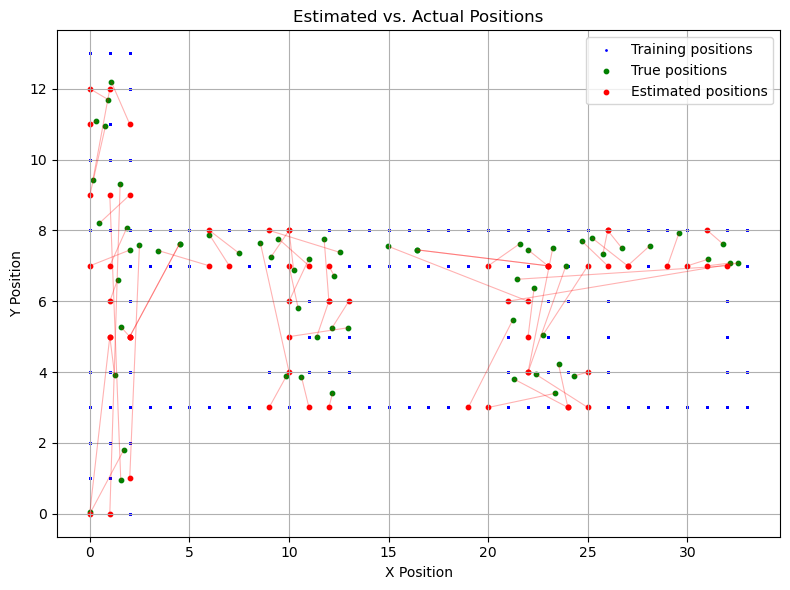

In [12]:
est_xy_m1_k1 =pred_xy(online_reshaped, offline_summary,num_angles=1, k=1)
 
plot_estimates(offline_summary, online_reshaped, est_xy_m1_k1)

In [13]:
compute_position_rmse(est_xy_m1_k1, online_reshaped)

3.649112574400132

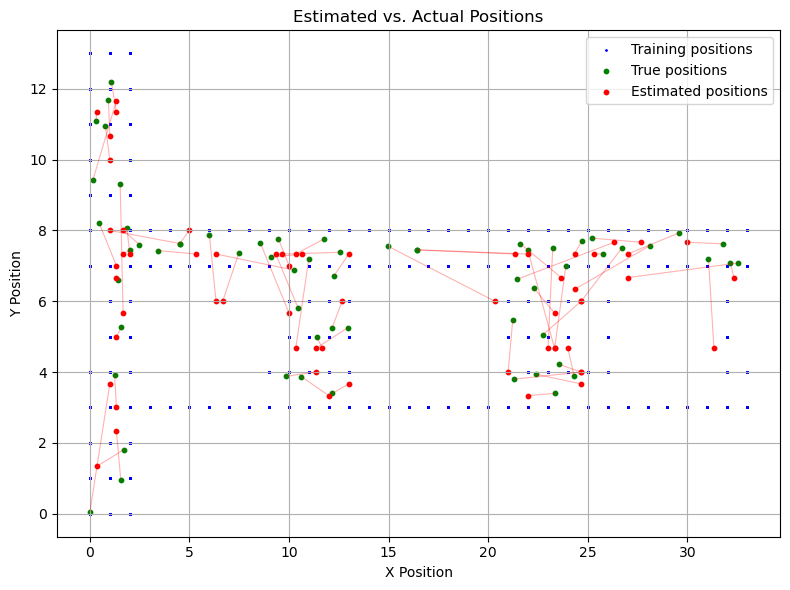

In [14]:
est_xy_m3_k3=pred_xy(online_reshaped, offline_summary,num_angles=3, k=3)
plot_estimates(offline_summary, online_reshaped, est_xy_m3_k3)

In [15]:
compute_position_rmse(est_xy_m3_k3, online_reshaped)

2.4384688038863405

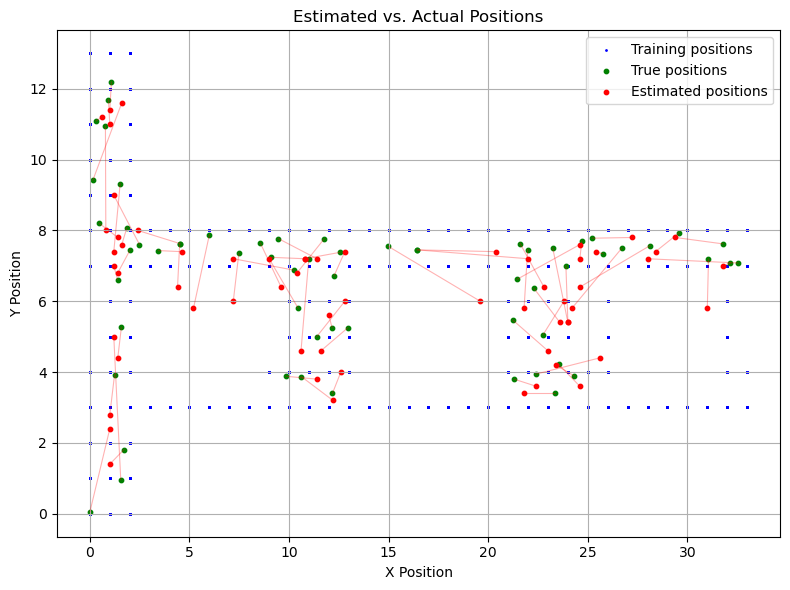

In [16]:
est_xy_m3_k5=pred_xy(online_reshaped, offline_summary,num_angles=3, k=5)
plot_estimates(offline_summary, online_reshaped, est_xy_m3_k5)

In [17]:
compute_position_rmse(est_xy_m3_k5, online_reshaped)

2.167819627063993

### Parameter selection and cross validation

The question of which value for k is the best, still remains, as well as the choce of m, the number of angles to condider.

Ideally, we want to choose the value of k independent of our test data so that we do not overfit our model to the training data. 

The method of v-fold cross-validation can help us do this:

we divide our training data into v non-overlapping subsets of equal size.

for each subset, we build models with the data that are not in that subset

and we assess the predictive ability of the model using the subset that was left out

We repeat this model fitting and assessment for each of the v folds and aggregate the prediction errors across the folds.

Recall that we have 166 locations, each with 8 orientations and measurements from 6 AP. We want to select one orientation at random for each location. 


In [18]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.base import BaseEstimator, RegressorMixin

class KNNIndoorLocator(BaseEstimator, RegressorMixin):
    def __init__(self, k=5, m=3, eps=1e-6):
        self.k = k
        self.m = m
        self.eps = eps

    def fit(self, X, y):
        # X: DataFrame with orientation_rounded + MAC cols
        # y: array (n_samples,2) with [posX,posY]
        df = X.reset_index(drop=True).copy()
        df['posX'], df['posY'] = y[:,0], y[:,1]
        if 'orientation_rounded' not in df.columns and 'orientation' in df.columns:
            df['orientation_rounded'] = (
                df['orientation'].astype(float).apply(round_orientation)
            )
        self.offline_summary_ = df
        return self

    def predict(self, X):
        preds = pred_xy(
            online_reshaped = X.reset_index(drop=True),
            offline_summary  = self.offline_summary_,
            num_angles       = self.m,
            k                = self.k
        )
        return preds[['predX','predY']].to_numpy()


In [39]:
X = offline_summary.drop(columns=['posX', 'posY'])
y = offline_summary[['posX', 'posY']].to_numpy()

X_v2 = offline_summary_v2.drop(columns=['posX', 'posY'])
y_v2 = offline_summary_v2[['posX', 'posY']].to_numpy()


# Set up a CV for GridSearch:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def grid_search(param_grid, X_data, y_data):

    grid = GridSearchCV(
        estimator = KNNIndoorLocator(),
        param_grid = param_grid,
        cv = cv,
        scoring = 'neg_root_mean_squared_error',  # built-in RMSE scorer (negated)
        n_jobs = -1,
        verbose = 1,
        error_score = 'raise'
    )
    
    # Run the grid search on the TRAINING split:
    grid.fit(X_data, y_data)
    
    print("Best hyperparameters:", grid.best_params_)
    print("Best CV RMSE:", -grid.best_score_)



In [40]:
grid_search({'k': [1, 5, 10, 15, 20], 'm': [1, 2, 3, 4, 5]}, X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters: {'k': 10, 'm': 4}
Best CV RMSE: 1.9028149375320484


In [41]:
grid_search({'k': [7,8,9,10,11,12,13], 'm': [3, 4, 5]}, X, y)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best hyperparameters: {'k': 8, 'm': 4}
Best CV RMSE: 1.8981194399433527


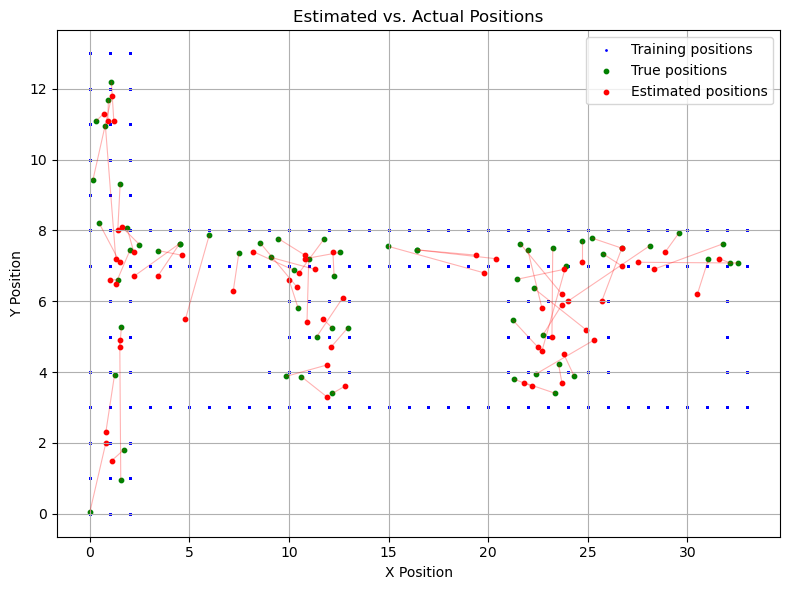

In [22]:
est_xy_m4_k10=pred_xy(online_reshaped, offline_summary,num_angles=4, k=10)
plot_estimates(offline_summary, online_reshaped, est_xy_m4_k10)

In [50]:
basic_RMSE = compute_position_rmse(est_xy_m4_k10, online_reshaped)
basic_RMSE

2.1183354694878527

## Weighted KNN

In [24]:
import numpy as np
import pandas as pd

def pred_xy_weighted(online_reshaped, offline_summary, num_angles=1, k=3, eps=1e-6):
    """
    Estimate X,Y coordinates for each new observation by finding the k closest
    records in offline_summary that have one of the num_angles nearest orientations,
    then computing the weighted average of their positions with weights
    w_i = (1 / (d_i + eps)) / sum_j(1 / (d_j + eps)).

    Parameters:
    - online_reshaped: pd.DataFrame with an 'orientation' or 'orientation_rounded' column
      plus one column per MAC (e.g. '00:11:22:33:44:55').
    - offline_summary: pd.DataFrame with ['posX','posY','orientation_rounded'] plus
      the same MAC‐columns.
    - num_angles: how many adjacent 45° bins to include.
    - k: number of nearest neighbors in signal‐space.
    - eps: small constant to avoid division by zero.

    Returns:
    - pd.DataFrame with columns ['predX','predY','distances'], where 'distances' is
      a list of the k raw signal‐distances used for each test row.
    """
    est_xy = []
    all_distances = []

    # Detect MAC columns (they all contain a colon)
    signal_cols = [c for c in online_reshaped.columns if ':' in c]

    for _, test_row in online_reshaped.iterrows():
        # 1) Find the nearest orientation bins
        ori = test_row.get('orientation_rounded', test_row['orientation'])
        target_bins = nearest_angles(ori, num_angles)

        # 2) Subset offline to those bins
        candidates = offline_summary[
            offline_summary['orientation_rounded'].isin(target_bins)
        ].copy()

        # 3) Compute Euclidean distance in signal‐space
        sig_cand = candidates[signal_cols].astype(float)
        sig_test = test_row[signal_cols].astype(float)
        diffs = sig_cand.subtract(sig_test, axis=1)
        distances = np.linalg.norm(diffs.to_numpy(), axis=1)
        candidates['signal_distance'] = distances

        # 4) Pick the k records with smallest signal_distance
        neighbors = candidates.nsmallest(k, 'signal_distance')
        d_k = neighbors['signal_distance'].values
        all_distances.append(d_k.tolist())

        # 5) Compute inverse‐distance weights and weighted position
        inv = 1.0 / (d_k + eps)
        w = inv / inv.sum()
        pred_x = np.sum(neighbors['posX'].values * w)
        pred_y = np.sum(neighbors['posY'].values * w)

        est_xy.append([pred_x, pred_y])

    result = pd.DataFrame(est_xy, columns=['predX', 'predY'])
    result['distances'] = all_distances
    return result


In [34]:
est_xy_m5_k9_switched=pred_xy(online_reshaped_v2, offline_summary_v2,num_angles=5, k=9)
#plot_estimates(offline_summary_v2, online_reshaped_v2, est_xy_m5_k9_switched)

In [25]:
class KNNIndoorLocatorWeighted(BaseEstimator, RegressorMixin):
    def __init__(self, k=5, m=3, eps=1e-6):
        self.k = k
        self.m = m
        self.eps = eps

    def fit(self, X, y):
        # X: DataFrame with orientation_rounded + MAC cols
        # y: array (n_samples,2) with [posX,posY]
        df = X.reset_index(drop=True).copy()
        df['posX'], df['posY'] = y[:,0], y[:,1]
        if 'orientation_rounded' not in df.columns and 'orientation' in df.columns:
            df['orientation_rounded'] = (
                df['orientation'].astype(float).apply(round_orientation)
            )
        self.offline_summary_ = df
        return self

    def predict(self, X):
        # no extra kwargs here – we use self.weighted internally
        preds = pred_xy_weighted(
            online_reshaped = X.reset_index(drop=True),
            offline_summary  = self.offline_summary_,
            num_angles       = self.m,
            k                = self.k,
            eps              = self.eps
        )
        return preds[['predX','predY']].to_numpy()


In [26]:
def grid_search_weighted(param_grid):

    grid = GridSearchCV(
        estimator = KNNIndoorLocator(),
        param_grid = param_grid,
        cv = cv,
        scoring = 'neg_root_mean_squared_error',  # built-in RMSE scorer (negated)
        n_jobs = -1,
        verbose = 1,
        error_score = 'raise'
    )

    # Run the grid search on the TRAINING split:
    grid.fit(X_train, y_train)

    print("Best hyperparameters:", grid.best_params_)
    print("Best CV RMSE:", -grid.best_score_)

    # Evaluate on the held-out 20%:
    y_pred = grid.predict(X_test)


In [27]:
grid_search_weighted({'k': [1, 5, 10, 15, 20], 'm': [1, 2, 3, 4, 5]})

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters: {'k': 10, 'm': 4}
Best CV RMSE: 1.8657688634665408


In [28]:
grid_search_weighted({'k': [7,8,9,10,11,12,13], 'm': [3, 4, 5]})

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best hyperparameters: {'k': 10, 'm': 4}
Best CV RMSE: 1.8657688634665408


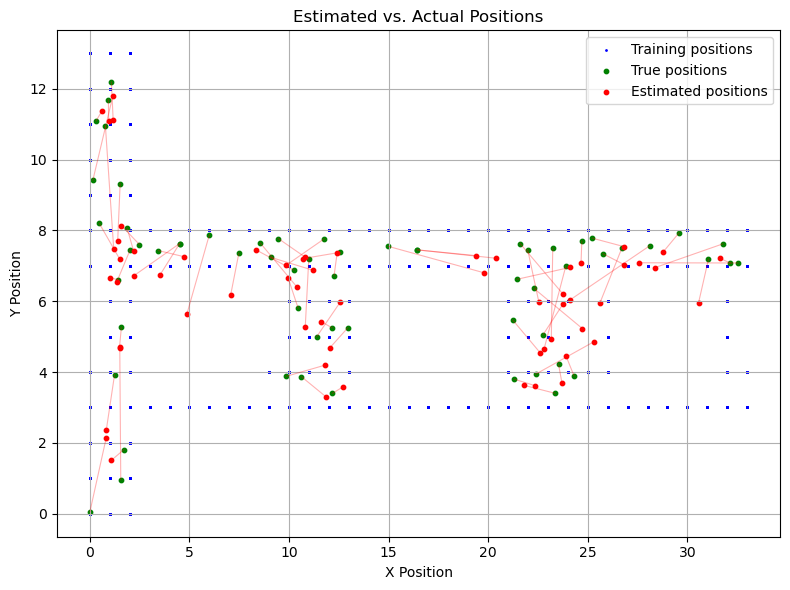

In [54]:
est_xy_m4_k10_weighted=pred_xy_weighted(online_reshaped, offline_summary,num_angles=4, k=10)
plot_estimates(offline_summary, online_reshaped, est_xy_m4_k10_weighted)

In [55]:
weighted_RMSE = compute_position_rmse(est_xy_m4_k10_weighted, online_reshaped)
weighted_RMSE

2.1086668543340616

## Switching out a MAC address

In [42]:
grid_search({'k': [1, 5, 10, 15, 20], 'm': [1, 2, 3, 4, 5]}, X_v2, y_v2)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters: {'k': 10, 'm': 4}
Best CV RMSE: 1.8435748313525004


In [43]:
grid_search({'k': [7,8,9,10,11,12,13], 'm': [3, 4, 5]}, X_v2, y_v2)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best hyperparameters: {'k': 10, 'm': 4}
Best CV RMSE: 1.8435748313525004


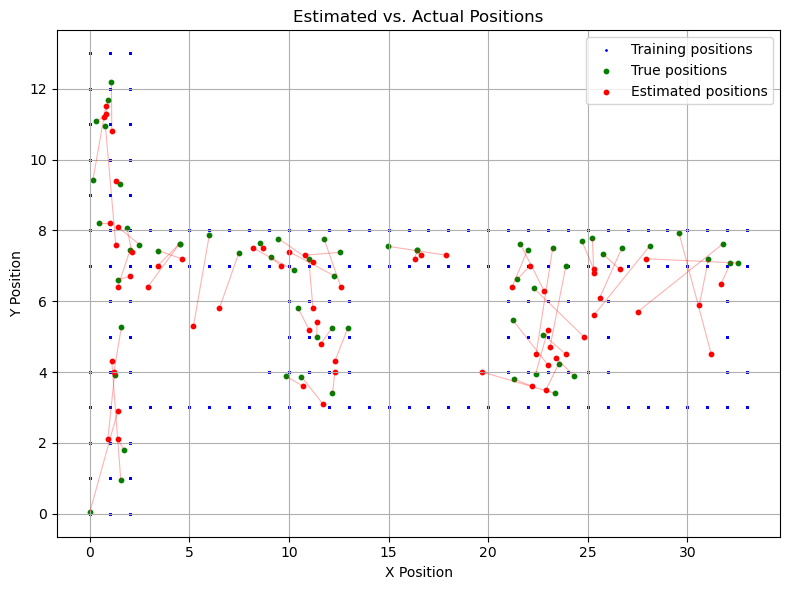

In [47]:
est_xy_m5_k9_switched=pred_xy(online_reshaped_v2, offline_summary_v2,num_angles=4, k=10)
plot_estimates(offline_summary_v2, online_reshaped_v2, est_xy_m5_k9_switched)

In [52]:
switched_RMSE = compute_position_rmse(est_xy_m5_k9_switched, online_reshaped_v2)
switched_RMSE

1.9488847100080664

In [56]:
model_comparison = {"model": ["basic", "weighted", "switched MAC"], 
                    "k": [10, 10, 9],
                    "m": [4, 4, 5],
                    "RMSE": [basic_RMSE, weighted_RMSE, switched_RMSE]}
comparison_df = pd.DataFrame(model_comparison)
display(comparison_df)

,model,k,m,RMSE
0,basic,10,4,2.118335
1,weighted,10,4,2.108667
2,switched MAC,9,5,1.948885
